# Style Transfer in Keras

Using CNNs and Gram Matrix.

Paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

In [1]:
import scipy.io
import scipy.misc
import tensorflow as tf
import numpy as np
import time
import imageio
from IPython.display import Image

# from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave #to be able to save as an image
from scipy.optimize import fmin_l_bfgs_b #to optimize our cost function

from keras.applications import vgg19 #to load vgg19 network
from keras import backend as K

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
print(tf.__version__)
print(keras.__version__)

from keras.utils.vis_utils import plot_model #to be able to visualize the network
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

1.12.0
2.1.6


In [89]:
content_file_name = 'base.jpg'#content image
style_file_name = 'darkside.png'#style image

In [90]:
iterations =20 # we will run 20 iterations during the optimization. 
# each iteration you get better value. this one is about 15 min. 

# these are the weights of the different loss components
total_variation_weight = 1.0 
style_weight = 1.0 #the best number authors got from their trials 
content_weight = 0.025 #the best number authors got from their trials 

In [91]:
# let's load images

# base_image_path = './images/'+content_file_name
base_image_path = './images/' + content_file_name
style_reference_image_path = './images/'+style_file_name

# get dimensions (width, height) of the generated picture
width, height = load_img(base_image_path).size

img_nrows = 400 #recale the image to 400 pixel rows 
img_ncols = int(width * img_nrows / height)

In [92]:
# pre-process the image: rescaling, running it through VGG19

def preprocess_image(image_path):

    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


# utility function to convert a tensor into a valid image

def deprocess_image(x):

    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))

    else:

        x = x.reshape((img_nrows, img_ncols, 3))

    # Remove zero-center by mean pixel

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'

    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

#calculating the mean pixel values of the VGG network. We will use these values for normalization.
#mean = data['meta'][0][0][2][0][0][2]
#mean_pixel = np.mean(mean, axis=(0, 1))
#print(mean_pixel)

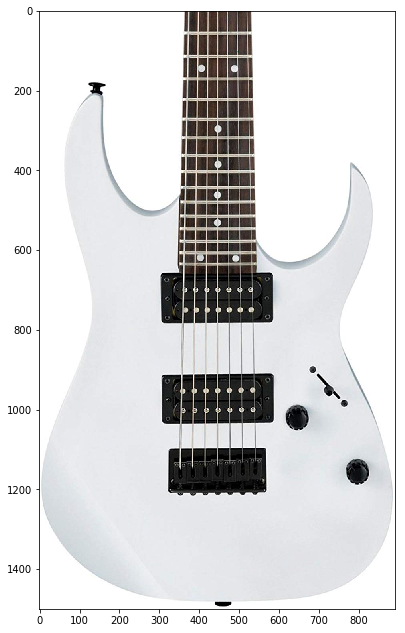

In [93]:
image_content = imageio.imread(base_image_path)
#image_content= scipy.misc.imresize(image_content,(224,224))
plt.figure(figsize=(11,11))
plt.imshow(image_content)

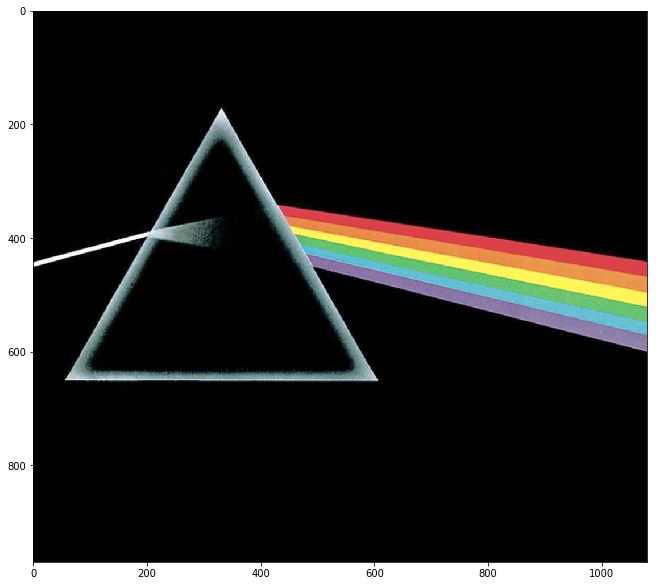

In [94]:
image_style = imageio.imread(style_reference_image_path)
#image_content= scipy.misc.imresize(image_content,(224,224))
plt.figure(figsize=(11,11))
plt.imshow(image_style)



In [95]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))


# combine the 3 images (style, content, result image that starts from the white noise) into a single Keras tensor

input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [96]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights

model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [97]:
# plot_model(model, show_shapes=True, to_file='./images/model.png')
# Image("./images/model.png")

In [98]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [99]:
for l, layer in enumerate(model.layers):
    print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [100]:
# compute the neural style loss
# first we need to define 4 utility functions
# the gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):

    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    gram = K.dot(features, K.transpose(features))
    return gram

In [101]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):

    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3

    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


In [102]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [103]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent (no big changes)

def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':

        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [104]:
# combine these loss functions into a single scalar

loss = K.variable(0.)
layer_features = outputs_dict['block5_conv2'] #content features
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

In [105]:
# style_features
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

In [106]:
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

loss += total_variation_weight * total_variation_loss(combination_image)

In [107]:
# get the gradients of the generated image wrt the loss

grads = K.gradients(loss, combination_image)
outputs = [loss]

if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

In [108]:
def eval_loss_and_grads(x):

    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))

    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values



In [109]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [110]:
evaluator = Evaluator()

In [111]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

In [112]:
result_prefix ='./images/results_'

In [113]:
# minimise the loss function

for i in range(iterations):

    print('Start of iteration', i)
    start_time = time.time()

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)

    print('Current loss value:', min_val)
    # save current generated image

    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img)
    end_time = time.time()

    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 17759200000.0
Image saved as ./images/results__at_iteration_0.png
Iteration 0 completed in 13s
Start of iteration 1
Current loss value: 13186613000.0
Image saved as ./images/results__at_iteration_1.png
Iteration 1 completed in 19s
Start of iteration 2
Current loss value: 11039589000.0
Image saved as ./images/results__at_iteration_2.png
Iteration 2 completed in 18s
Start of iteration 3
Current loss value: 9823663000.0
Image saved as ./images/results__at_iteration_3.png
Iteration 3 completed in 19s
Start of iteration 4
Current loss value: 9101341000.0
Image saved as ./images/results__at_iteration_4.png
Iteration 4 completed in 19s
Start of iteration 5
Current loss value: 8654976000.0
Image saved as ./images/results__at_iteration_5.png
Iteration 5 completed in 18s
Start of iteration 6
Current loss value: 8324320000.0
Image saved as ./images/results__at_iteration_6.png
Iteration 6 completed in 18s
Start of iteration 7
Current loss value: 8078150700.

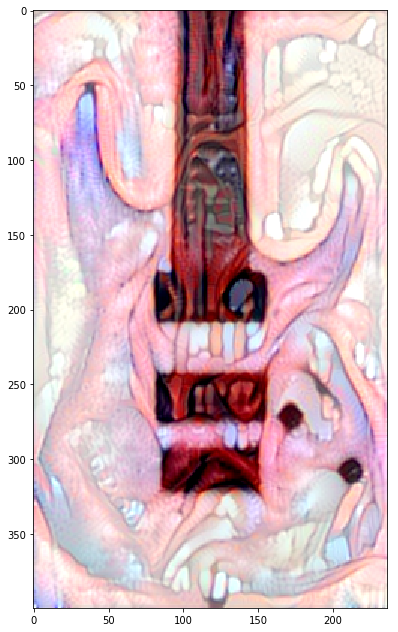

In [88]:
#image_content= scipy.misc.imresize(image_content,(224,224))
plt.figure(figsize=(11,11))
plt.imshow(img)

## References
- Adapted from https://github.com/kangeunsu/ArtML/tree/master/Style_Transfer_Tensorflow
- Additional style transfer reading: https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199